<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b> Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Part 1. Data preparation

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/data/GAN/thumbnails128x128.zip'

In [ ]:
DATA_DIR = '/content/thumbnails128x128'

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
from PIL import Image
import torchvision.transforms as tt

class ImageDataset(Dataset):
    def __init__(self, root_path, image_size):
        self.img_paths = []
        self.transform = tt.Compose([tt.Resize(image_size),
            tt.CenterCrop(image_size),
            tt.ToTensor()])
        for root, dirs, files in os.walk(DATA_DIR):
            if root == DATA_DIR:
                continue
            for img_name in files:
                self.img_paths.append(os.path.join(root, img_name))
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        return self.transform(Image.open(self.img_paths[idx]))

In [ ]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  
  dataset = ImageDataset(DATA_DIR, image_size)

  return dataset, DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
image_size = 128
batch_size = 32

images = []
dls = []

dataset, train_dl = get_dataloader(image_size, batch_size)

## Part 2. Model architecture and traing

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
discriminator = nn.Sequential(
    #in: 3 x 128 x 128
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    # 64 x 64 x 64
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    # 128 x 32 x 32
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    # 256 x 16 x 16
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    # 512 x 8 x 8
    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),

    # 1024 x 4 x 4
    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),

    # 1 x 1 x 1
    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
latent_size = 128 # choose latent size

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Sigmoid()
    #out: 3 x 128 x 128
)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 0.0001

generator.to(device)
discriminator.to(device)

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss().to(device),
    "generator": nn.BCELoss().to(device)
}

In [ ]:
def fit(model, criterion, epochs, lr):
    model["discriminator"].train()
    model["generator"].train()
    
    losses_g = []
    losses_d = []

    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                            lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                        lr=lr, betas=(0.5, 0.999))
    }
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_scores = []
        fake_scores = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images in tqdm(train_dl):
            real_images = real_images.to(device)
            # Discriminator training
            optimizer["discriminator"].zero_grad()
            
            # Pass real images through discriminator
            
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images and pass them through discriminator
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Generator training
            optimizer["generator"].zero_grad()
            
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            images = model["generator"](latent)

            targets = torch.ones(batch_size, 1, device=device)
            preds = model["discriminator"](images)
            loss_g = criterion["generator"](preds, targets)

            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_d.append(np.mean(loss_d_per_epoch))
        losses_g.append(np.mean(loss_g_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print(f"Epoch [{epoch+1}/{epochs}], loss_g: {losses_g[-1]:.4f}, loss_d: {losses_d[-1]:.4f}, real_score: {real_scores[-1]:.4f}, fake_score: {fake_scores[-1]:.4f}")

    return losses_g, losses_d, real_scores, fake_scores


Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [ ]:
epochs = 4  # will be 40 for the final model

losses_g, losses_d, real_scores, fake_scores = fit(model, criterion, epochs, lr)

  0%|          | 0/2048 [00:00<?, ?it/s]

Epoch [1/4], loss_g: 6.8324, loss_d: 0.3607, real_score: 0.9080, fake_score: 0.0926


  0%|          | 0/2048 [00:00<?, ?it/s]

Epoch [2/4], loss_g: 5.6629, loss_d: 0.3808, real_score: 0.8816, fake_score: 0.1161


  0%|          | 0/2048 [00:00<?, ?it/s]

Epoch [3/4], loss_g: 6.2503, loss_d: 0.2871, real_score: 0.9106, fake_score: 0.0881


  0%|          | 0/2048 [00:00<?, ?it/s]

Epoch [4/4], loss_g: 6.6572, loss_d: 0.2316, real_score: 0.9277, fake_score: 0.0717


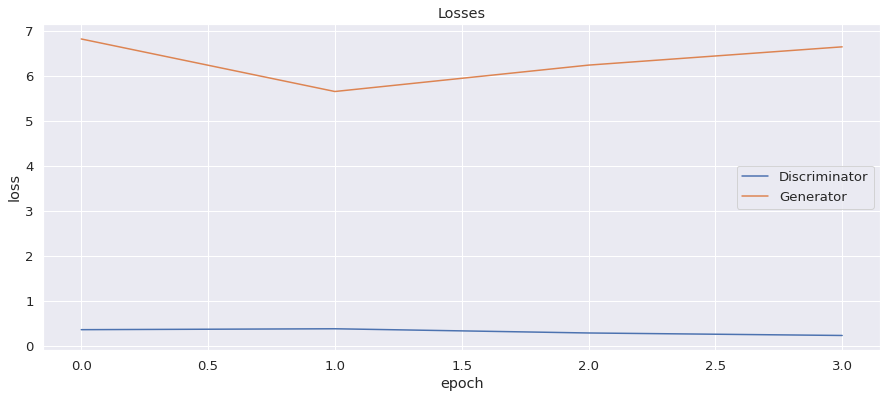

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

## Part 3. Generating images

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [ ]:
def show_images(images, nmax=64):
    # TODO: show generated images
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow((make_grid(images.detach().cpu()[:nmax], nrow=8).permute(1, 2, 0)))

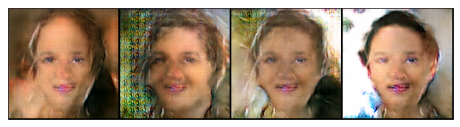

In [ ]:
show_images(fake_images)

Как вам качество получившихся изображений?

## Part 4. Leave-one-out-1-NN classifier accuracy

### 4.1. Get accuracy

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
inception = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True).to(device)
inception.fc = nn.Identity()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

sample_size = 1024

latent = torch.randn(sample_size, latent_size, 1, 1, device=device)
fake_images = model['generator'](latent).squeeze(0).cpu().view(sample_size // batch_size, batch_size, 3, 128, 128)
fake_targets = torch.zeros(sample_size)

In [ ]:
real_lst = []
for idx, img in enumerate(train_dl):
    if idx == sample_size // batch_size:
        break
    real_lst.append(img)

In [ ]:
real_images = torch.stack(real_lst, axis=0)
real_targets = torch.ones(sample_size)

In [ ]:
print(fake_images.shape, real_images.shape)

In [ ]:
all_images = torch.cat((fake_images, real_images))
all_images = torch.stack([tt.Resize(299)(img) for img in all_images])

all_targets = torch.cat((fake_targets, real_targets))
loo = LeaveOneOut()

In [ ]:
train_img_features = []
for batch in all_images:
    train_img_features.append(inception(batch.to(device)).logits.cpu())
train_img_features = torch.cat(train_img_features)

In [ ]:
preds = []
targets = []

for train_idx, test_idx in loo.split(real_targets):
  
    train_idx = np.array(train_idx)
    test_idx = np.array(test_idx)
    
    classifier = KNeighborsClassifier(n_neighbors=1)

    test_img_features = inception(all_images[test_idx]).cpu()

    classifier.fit(train_img_features, all_targets[train_idx])
    pred = classifier.transform(test_img_features)

    preds.append(preds)
    targets.append(all_targets[test_idx])

accuracy_score(preds, targets)

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?